In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [2]:
# --- 1. 데이터 로드 함수 정의 (제시된 코드와 동일) ---

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # prefix 경로는 사용자 환경에 맞게 조정되었습니다.
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(f"로드된 데이터 Shape:")
    print(f"Train X: {trainX.shape}, Train Y (One-Hot): {trainy_one_hot.shape}")
    print(f"Test X: {testX.shape}, Test Y (One-Hot): {testy_one_hot.shape}")
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
# --- 2. 데이터 로드 및 분할 ---

# 데이터 로드
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# 훈련/검증 데이터 분할 (trainX의 20%를 검증 데이터로 사용)
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    trainX, trainy_one_hot, test_size=0.2, random_state=100
)

# 모델에 사용할 차원 정의
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]
print(f"\n모델 입력 정의: Timesteps={n_timesteps}, Features={n_features}, Outputs={n_outputs}")

/tmp/ipython-input-1324026098.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1324026098.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1324026098.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1324026098.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


로드된 데이터 Shape:
Train X: (7352, 128, 9), Train Y (One-Hot): (7352, 6)
Test X: (2947, 128, 9), Test Y (One-Hot): (2947, 6)

모델 입력 정의: Timesteps=128, Features=9, Outputs=6


/tmp/ipython-input-1324026098.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [4]:
# --- 3. Simple CNN 모델 정의 ---

def create_simple_cnn(timesteps, features, outputs):
    model = Sequential()

    # Convolutional Layer 1: 특징 추출
    model.add(Conv1D(
        filters=64,
        kernel_size=3,              # 작은 커널 크기 사용
        activation='relu',
        input_shape=(timesteps, features)
    ))

    # Max Pooling Layer 1: 차원 축소 및 중요한 특징만 남김
    model.add(MaxPooling1D(pool_size=2))

    # Convolutional Layer 2: 더 깊은 특징 추출
    model.add(Conv1D(
        filters=128,
        kernel_size=3,
        activation='relu'
    ))

    # Max Pooling Layer 2: 최종 차원 축소
    model.add(MaxPooling1D(pool_size=2))

    # Flatten Layer: Dense Layer로 전달을 위해 1차원으로 펼침
    model.add(Flatten())

    # Dense Layer (Fully Connected)
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))  # 과적합 방지를 위한 Dropout

    # Output Layer: 클래스 개수만큼 출력, 다중 분류를 위한 Softmax 활성화 함수
    model.add(Dense(outputs, activation='softmax'))

    # 모델 컴파일
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 모델 생성
simple_cnn_model = create_simple_cnn(n_timesteps, n_features, n_outputs)
simple_cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       384,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,202 (1.57 MB)

 Trainable params: 411,202 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- 4. 모델 훈련 ---

print("\n--- 모델 훈련 시작 ---")
history = simple_cnn_model.fit(
    X_train, y_train_one_hot,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)


--- 모델 훈련 시작 ---
Epoch 1/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6752 - loss: 0.8391 - val_accuracy: 0.9055 - val_loss: 0.2509
Epoch 2/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9172 - loss: 0.2279 - val_accuracy: 0.9388 - val_loss: 0.1443
Epoch 3/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9417 - loss: 0.1560 - val_accuracy: 0.9429 - val_loss: 0.1298
Epoch 4/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9525 - loss: 0.1248 - val_accuracy: 0.9477 - val_loss: 0.1197
Epoch 5/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9495 - loss: 0.1222 - val_accuracy: 0.9456 - val_loss: 0.1249
Epoch 6/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9537 - loss: 0.1096 - val_accuracy: 0.9511 - val_loss: 0.1095
Epoch 7/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9579 - loss: 0.1078 - val_accuracy: 0.9517 - val_loss: 0.1259
Epoch 8/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9606 - loss: 0.1013

In [6]:
# --- 5. 모델 테스트 및 평가 ---

print("\n--- 모델 테스트 (Test Data 평가) ---")

# load_dataset 함수에서 반환된 testX와 testy_one_hot 사용
# testX, testy_one_hot 변수가 load_dataset 호출 시 전역으로 설정되었다고 가정
loss, accuracy = simple_cnn_model.evaluate(testX, testy_one_hot, batch_size=32, verbose=0)

print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")


--- 모델 테스트 (Test Data 평가) ---
테스트 데이터 손실 (Loss): 0.6564
테스트 데이터 정확도 (Accuracy): 0.9209


In [7]:
# --- 6. 훈련 과정 시각화 ---

# 훈련 기록(History) 객체에서 필요한 데이터 추출
history_dict = history.history

# 손실 (Loss) 데이터
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# 정확도 (Accuracy) 데이터
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

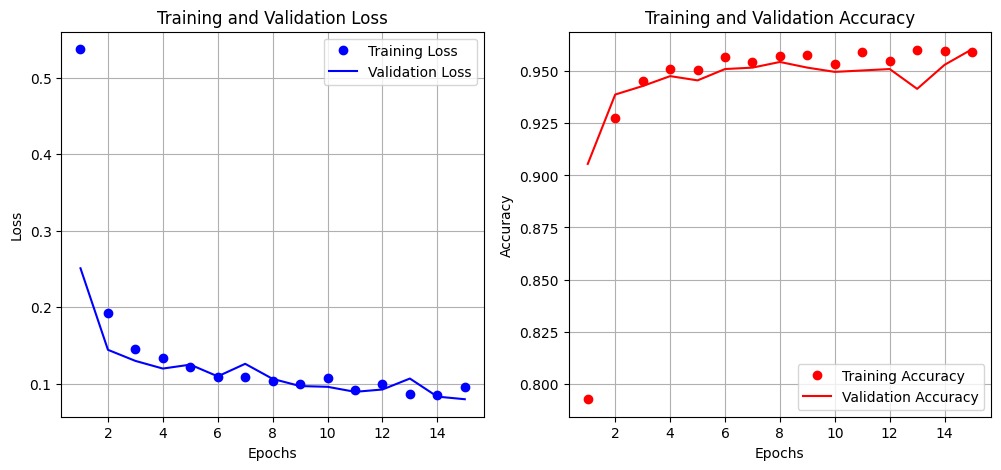

--- 시각화 완료: 손실 및 정확도 그래프 출력 ---


In [8]:
# --- 7. 그래프 출력 ---

# 7-1. 손실(Loss) 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 그래프
plt.plot(epochs, loss_values, 'bo', label='Training Loss')  # 'bo'는 파란색 점선
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss') # 'b'는 파란색 실선
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 7-2. 정확도(Accuracy) 그래프
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 그래프
plt.plot(epochs, acc_values, 'ro', label='Training Accuracy') # 'ro'는 빨간색 점선
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy') # 'r'는 빨간색 실선
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("--- 시각화 완료: 손실 및 정확도 그래프 출력 ---")